# Data Preprocessing

In [96]:
# In[1] ─ Imports & Setup  (unchanged)
import os, urllib.parse, pandas as pd, numpy as np
from dotenv import load_dotenv
from sqlalchemy import create_engine
pd.set_option('display.max_columns', None)

# In[2] ─ Load environment and connect to MySQL  (unchanged)
load_dotenv()
user   = os.getenv("MYSQL_USER")
pw     = urllib.parse.quote_plus(os.getenv("MYSQL_PASSWORD"))
host   = os.getenv("MYSQL_HOST")
port   = os.getenv("MYSQL_PORT")
db     = os.getenv("MYSQL_DATABASE")
engine = create_engine(f"mysql+pymysql://{user}:{pw}@{host}:{port}/{db}")

# -------------------------------------------------------------------
# 1) Load raw tables (unchanged)
ohlcv = pd.read_sql_query(
    "SELECT datetime, open, high, low, close, volume "
    "FROM ohlcv WHERE timeframe='1h'",
    engine, parse_dates=['datetime'], index_col='datetime'
)
ta = pd.read_sql_table(
    'ta_features_1h', engine,
    index_col='datetime', parse_dates=['datetime']
)

# 2) Drop bad TA columns and align start (unchanged)
ta = ta.drop(columns=['TEMA_real', 'TRIX_real'], errors='ignore')
first_valid_dates = [ta[col].first_valid_index() for col in ta.columns]
start_date = max(d for d in first_valid_dates if d is not None)
ta    = ta.loc[start_date:]
ohlcv = ohlcv.loc[start_date:]

# 3) Impute OHLCV & TA fully (unchanged)
ohlcv_ffb = ohlcv.ffill().bfill()
ta_ffb    = ta.ffill().bfill()

# -------------------------------------------------------------------
# 4) **NEW** ─ Build regression target and classification label FIRST
ret1  = ohlcv_ffb['close'].pct_change().rename('ret1')

delta = 0.0015                       # 0.1 % threshold
dir_  = pd.Series(
    np.where(ret1 >  delta,  2,
    np.where(ret1 < -delta, 0, 1)),
    index=ret1.index,
    name='dir'
)

# dir_  = pd.Series(
#     np.where(ret1 >= 0, 0, 1),
#     index=ret1.index,
#     name='dir'
# )

# 5) **MODIFIED** ─ Merge everything in ONE concat (prevents fragmentation)
price_cols = ['open', 'high', 'low', 'close', 'volume']
df_all = pd.concat(
    [
        ohlcv_ffb,
        ta_ffb.drop(columns=price_cols),
        ret1,
        dir_                                  # ← classification column
    ],
    axis=1,
    join='inner'
)

# 6) **MODIFIED location** ─ Drop rows where ret1 is NaN (first row)
df_all = df_all.dropna(subset=['ret1'])

# 7) Drop constant columns (run once)
const_cols = [c for c in df_all.columns if df_all[c].nunique() <= 1]
df_all = df_all.drop(columns=const_cols)

# 8) Ensure column names are strings (unchanged)
df_all.columns = df_all.columns.map(str)

# 9) Optional: de‑fragment explicitly (harmless copy)
df_all = df_all.copy()

# -------------------------------------------------------------------
# 10) Quick sanity‑check: class distribution
print("Class distribution:\n", df_all['dir'].value_counts())
df_all.head()


Class distribution:
 dir
1    11802
2    10896
0    10507
Name: count, dtype: int64


,open,high,low,close,volume,HT_DCPERIOD_real,HT_DCPHASE_real,HT_PHASOR_inphase,HT_PHASOR_quadrature,HT_SINE_sine,HT_SINE_leadsine,HT_TRENDMODE_integer,ADD_real,DIV_real,MAX_real,MAXINDEX_integer,MIN_real,MININDEX_integer,MINMAX_min,MINMAX_max,MINMAXINDEX_minidx,MINMAXINDEX_maxidx,MULT_real,SUB_real,SUM_real,ATAN_real,CEIL_real,COS_real,FLOOR_real,LN_real,LOG10_real,SIN_real,SQRT_real,TAN_real,ADX_real,ADXR_real,APO_real,AROON_aroondown,AROON_aroonup,AROONOSC_real,BOP_real,CCI_real,CMO_real,DX_real,MACD_macd,MACD_macdsignal,MACD_macdhist,MACDEXT_macd,MACDEXT_macdsignal,MACDEXT_macdhist,MACDFIX_macd,MACDFIX_macdsignal,MACDFIX_macdhist,MFI_real,MINUS_DI_real,MINUS_DM_real,MOM_real,PLUS_DI_real,PLUS_DM_real,PPO_real,ROC_real,ROCP_real,ROCR_real,ROCR100_real,RSI_real,STOCH_slowk,STOCH_slowd,STOCHF_fastk,STOCHF_fastd,STOCHRSI_fastk,STOCHRSI_fastd,ULTOSC_real,WILLR_real,BBANDS_upperband,BBANDS_middleband,BBANDS_lowerband,DEMA_real,EMA_real,HT_TRENDLINE_real,KAMA_real,MA_real,MAMA_mama,MAMA_fama,MIDPOINT_real,MIDPRICE_real,SAR_real,SAREXT_real,SMA_real,T3_real,TRIMA_real,WMA_real,CDL3WHITESOLDIERS_integer,CDLADVANCEBLOCK_integer,CDLBELTHOLD_integer,CDLCLOSINGMARUBOZU_integer,CDLDOJI_integer,CDLDRAGONFLYDOJI_integer,CDLENGULFING_integer,CDLGRAVESTONEDOJI_integer,CDLHAMMER_integer,CDLHANGINGMAN_integer,CDLHARAMI_integer,CDLHARAMICROSS_integer,CDLHIGHWAVE_integer,CDLHIKKAKE_integer,CDLHIKKAKEMOD_integer,CDLIDENTICAL3CROWS_integer,CDLLONGLEGGEDDOJI_integer,CDLLONGLINE_integer,CDLMARUBOZU_integer,CDLMATCHINGLOW_integer,CDLRICKSHAWMAN_integer,CDLSEPARATINGLINES_integer,CDLSHORTLINE_integer,CDLSPINNINGTOP_integer,CDLSTALLEDPATTERN_integer,CDLTAKURI_integer,AVGPRICE_real,MEDPRICE_real,TYPPRICE_real,WCLPRICE_real,BETA_real,CORREL_real,LINEARREG_real,LINEARREG_ANGLE_real,LINEARREG_INTERCEPT_real,LINEARREG_SLOPE_real,STDDEV_real,TSF_real,VAR_real,ATR_real,NATR_real,TRANGE_real,AD_real,ADOSC_real,OBV_real,ret1,dir
datetime,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-07-08 04:00:00,33320.02,33354.00,33181.00,33300.76,0.398287,27.353440,312.950019,-858.674980,-1003.307868,-0.731948,-0.035771,1.0,66535.00,1.005214,34852.5,48.0,33251.46,60.0,33251.46,34852.5,60.0,48.0,1.106719e+09,173.00,1030015.18,1.570766,33301.0,0.992552,33300.0,10.413335,4.522454,-0.121825,182.484958,-0.122739,28.640298,23.890103,-403.519808,92.857143,0.000000,-92.857143,-0.111329,-98.078973,-44.587524,56.114196,-283.777197,-126.803072,-156.974125,-403.519808,-102.594815,-300.924993,-268.068535,-118.582280,-149.486255,25.733512,36.256245,1439.035065,-1379.31,10.192119,404.532147,-1.174703,-3.977241,-0.039772,0.960228,96.022759,27.706238,22.129392,17.480813,25.963958,22.129392,74.994433,4.563730e+01,39.811681,-87.293305,33400.625839,33318.512,33236.398161,33959.904316,34105.219388,34393.058843,34053.621264,34333.839333,33662.268669,34152.471168,33965.765,33939.695,33920.398439,-33920.398439,34333.839333,33357.828236,34531.668083,34163.920065,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,100.0,0.0,0.0,0.0,100.0,0.0,0.0,-100.0,0.0,0.0,33288.9450,33267.500,33278.586667,33284.1300,0.126478,0.972974,33182.253714,-89.562749,34885.694857,-131.033934,41.056920,33051.219780,1685.670655,284.051841,0.852989,173.00,-1.136618,-0.160647,-3.859353,-0.000578,1
2021-07-08 05:00:00,33300.76,33344.94,33124.37,33154.83,0.483069,27.427016,-43.303406,-1313.839928,-496.092382,-0.685862,0.029607,1.0,66469.31,1.006659,34852.5,48.0,33154.83,65.0,33154.83,34852.5,65.0,48.0,1.104530e+09,220.57,1028945.56,1.570766,33155.0,0.031925,33154.0,10.408944,4.520547,-0.999490,182.084678,-31.307531,30.703096,24.406991,-477.621795,85.714286,21.428571,-64.285714,-0.661604,-90.679108,-48.865931,57.519474,-313.462145,-164.134887,-149.327258,-477.621795,-175.132429,-302.489366,-296.579597,-154.181743,-142.397854,23.937476,35.658713,1392.876846,-1473.97,9.616594,375.636994,-1.392428,-4.256486,-0.042565,0.957

<Axes: title={'center': 'BTCUSDT Price Direction Data'}, xlabel='datetime'>

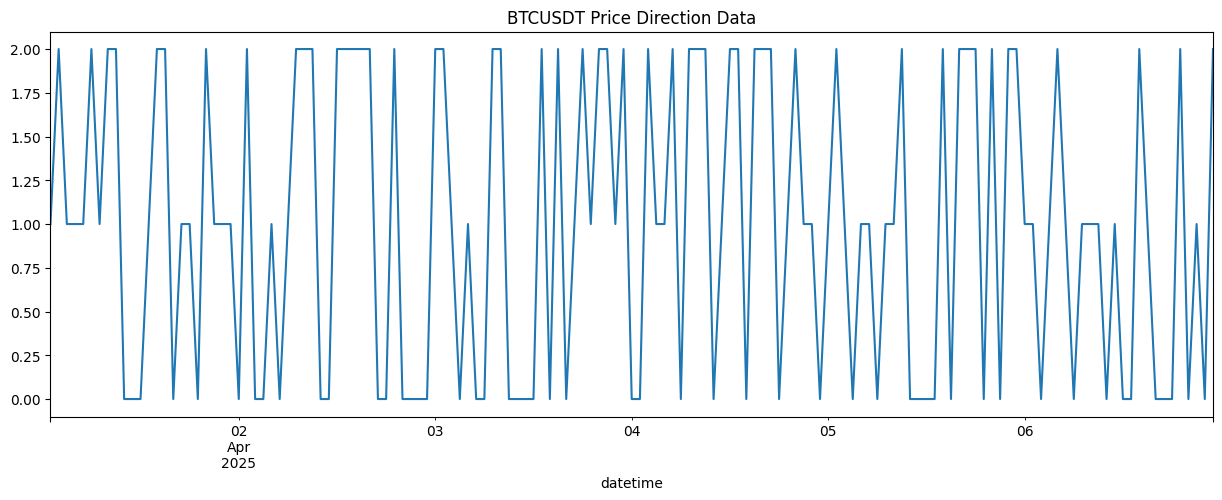

In [97]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15,5))
df_all['dir'].loc[(df_all.index > '2025-04-01') & (df_all.index < '2025-04-07')].plot(ax=ax,title='BTCUSDT Price Direction Data')

# Feature Engineering and Selection

In [99]:
import pandas as pd, numpy as np
from sklearn.compose         import ColumnTransformer
from sklearn.preprocessing   import RobustScaler
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import mutual_info_classif

# ── CONFIG ─────────────────────────────────────────────────────────────
TARGET      = 'dir'
MAX_LAG     = 14
N_SPLITS    = 5
KEEP_PCT    = 0.30
HEAVY_PREF  = ('volume','ATR','OBV')

# 1) Prepare X_final, y (mutual-info lag selection) ─────────────────────
y  = df_all[TARGET]
X0 = df_all.drop(columns=[TARGET])

# build lags 1…MAX_LAG
frames = [X0.shift(L).add_suffix(f'_lag{L}') for L in range(1, MAX_LAG+1)]
X_lag = pd.concat(frames, axis=1).dropna()
y     = y.loc[X_lag.index]

# robust-scale heavy tails
heavy = [c for c in X_lag.columns if c.startswith(HEAVY_PREF)]
ct = ColumnTransformer([
    ('robust', RobustScaler(), heavy),
    ('keep',   'passthrough', [c for c in X_lag.columns if c not in heavy])
])

# avg MI over folds
mi = pd.Series(0.0, index=X_lag.columns)
tscv = TimeSeriesSplit(n_splits=N_SPLITS)
for tr, _ in tscv.split(X_lag):
    Xtr = ct.fit_transform(X_lag.iloc[tr])
    ytr = y.iloc[tr]
    mi  += mutual_info_classif(Xtr, ytr, discrete_features=False)
mi /= N_SPLITS

# keep top KEEP_PCT of lags
k        = int(len(mi) * KEEP_PCT)
top_feats= mi.nlargest(k).index
X_red    = X_lag[top_feats]
X_red

,CEIL_real_lag13,MACDEXT_macdhist_lag3,MINUS_DM_real_lag2,MACDEXT_macd_lag4,ADXR_real_lag2,DX_real_lag6,LN_real_lag10,MACDFIX_macd_lag5,MOM_real_lag1,RSI_real_lag1,CCI_real_lag8,MACD_macdhist_lag5,MACD_macd_lag5,MINMAXINDEX_minidx_lag13,MACDEXT_macd_lag6,MINUS_DI_real_lag3,SUB_real_lag12,ADXR_real_lag8,SUM_real_lag12,MACDEXT_macdhist_lag5,AROON_aroondown_lag9,PLUS_DM_real_lag2,MACDFIX_macd_lag3,ATAN_real_lag5,ADX_real_lag9,ATAN_real_lag12,CCI_real_lag6,LN_real_lag12,MFI_real_lag4,MOM_real_lag3,MACD_macdhist_lag6,SIN_real_lag11,ROCR_real_lag1,MACD_macdsignal_lag5,FLOOR_real_lag12,MINMAX_max_lag13,MINMAXINDEX_maxidx_lag2,MINUS_DM_real_lag3,MACD_macd_lag6,CEIL_real_lag12,volume_lag1,MACDEXT_macd_lag5,DX_real_lag7,FLOOR_real_lag11,PPO_real_lag2,MACDFIX_macdhist_lag3,ADXR_real_lag10,MACDFIX_macdhist_lag4,SUM_real_lag13,ROCP_real_lag1,PLUS_DI_real_lag2,CMO_real_lag6,MFI_real_lag2,MACDFIX_macdsignal_lag2,SIN_real_lag10,SQRT_real_lag9,PLUS_DM_real_lag1,SIN_real_lag3,MACDFIX_macd_lag4,MININDEX_integer_lag14,BOP_real_lag7,MINMAX_max_lag14,MACD_macd_lag7,TAN_real_lag2,SIN_real_lag2,ATAN_real_lag13,MACDEXT_macdhist_lag4,MINMAX_min_lag14,SQRT_real_lag11,FLOOR_real_lag10,MINMAXINDEX_minidx_lag14,APO_real_lag9,ATAN_real_lag11,ADX_real_lag8,MOM_real_lag2,SUB_real_lag14,MACD_macdhist_lag4,COS_real_lag11,ADX_real_lag2,CEIL_real_lag11,MINUS_DI_real_lag1,TAN_real_lag10,BOP_real_lag6,SQRT_real_lag10,BOP_real_lag8,LOG10_real_lag10,SIN_real_lag9,MULT_real_lag14,TAN_real_lag9,AROON_aroonup_lag9,AROON_aroonup_lag7,MULT_real_lag13,MACDEXT_macdsignal_lag5,AROON_aroondown_lag8,AROON_aroonup_lag8,MINUS_DI_real_lag2,LN_real_lag11,DX_real_lag5,ADX_real_lag10,APO_real_lag8,MACD_macdsignal_lag6,HT_PHASOR_inphase_lag11,MIN_real_lag14,ADXR_real_lag9,MACDFIX_macdsignal_lag4,MINMAXINDEX_maxidx_lag13,AROONOSC_real_lag8,MINMAXINDEX_maxidx_lag14,MACDFIX_macdsignal_lag3,MIN_real_lag1,CDLLONGLINE_integer_lag4,AROONOSC_real_lag7,ROC_real_lag1,MINMAX_max_lag7,SMA_real_lag4,CDLSEPARATINGLINES_integer_lag5,COS_real_lag12,high_lag1,CCI_real_lag7,FLOOR_real_lag4,CDLTAKURI_integer_lag4,MACDFIX_macdhist_lag2,CORREL_real_lag1,CORREL_real_lag2,volume_lag12,CDLHIKKAKE_integer_lag7,LOG10_real_lag11,CORREL_real_lag3,CDLSTALLEDPATTERN_integer_lag3,PPO_real_lag3,MFI_real_lag3,TYPPRICE_real_lag2,SUB_real_lag13,T3_real_lag13,MULT_real_lag12,HT_PHASOR_quadrature_lag9,MACDEXT_macdsignal_lag4,AROON_aroondown_lag7,SQRT_real_lag3,PLUS_DI_real_lag1,CDLDOJI_integer_lag11,OBV_real_lag13,CDLHAMMER_integer_lag6,MACDEXT_macdsignal_lag3,CDL3WHITESOLDIERS_integer_lag12,MINUS_DM_real_lag1,PPO_real_lag1,ROCP_real_lag2,HT_SINE_sine_lag8,HT_SINE_leadsine_lag1,BETA_real_lag2,CDLLONGLINE_integer_lag6,TRIMA_real_lag13,FLOOR_real_lag3,LINEARREG_ANGLE_real_lag1,LOG10_real_lag3,MINMAX_max_lag9,SUB_real_lag2,CDLTAKURI_integer_lag3,CDLLONGLEGGEDDOJI_integer_lag7,SUB_real_lag6,WCLPRICE_real_lag1,HT_PHASOR_quadrature_lag7,CDLHANGINGMAN_integer_lag9,MACDFIX_macdhist_lag5,CMO_real_lag7,CDLSPINNINGTOP_integer_lag1,CDLHIGHWAVE_integer_lag8,TRANGE_real_lag14,CDLADVANCEBLOCK_integer_lag12,CDLBELTHOLD_integer_lag8,CDLGRAVESTONEDOJI_integer_lag10,LINEARREG_real_lag1,MOM_real_lag4,TYPPRICE_real_lag4,CDLSEPARATINGLINES_integer_lag4,MINMAXINDEX_minidx_lag9,CDLCLOSINGMARUBOZU_integer_lag11,SAREXT_real_lag11,MEDPRICE_real_lag3,low_lag11,SIN_real_lag1,CDLSHORTLINE_integer_lag4,HT_PHASOR_quadrature_lag1,ADXR_real_lag4,CDLIDENTICAL3CROWS_integer_lag7,MULT_real_lag1,CDLHIKKAKE_integer_lag8,CDLDRAGONFLYDOJI_integer_lag1,CDLSPINNINGTOP_integer_lag6,WMA_real_lag10,low_lag1,CDLENGULFING_integer_lag10,CDLSTALLEDPATTERN_integer_lag4,ATAN_real_lag1,MULT_real_lag6,high_lag13,LN_real_lag4,PLUS_DM_real_lag3,MIDPRICE_real_lag5,LINEARREG_INTERCEPT_real_lag1,open_lag11,CDLHARAMI_integer_lag9,DIV_real_lag9,PLUS_DI_real_lag4,CDLSEPARATINGLINES_integer_lag3,SAREXT_real_lag14,TYPPRICE_real_lag14,CDLDRAGONFLYDOJI_integer_lag9,T3_real_lag11,MACD_macd_lag1,CDLSTALLEDPATTERN_integer_lag1,CDLHAMMER_integer_lag1,DIV_real_lag11,SAR_real_lag11,MACDEXT_

In [100]:
# X is your DataFrame of selected features
corr = X_red.corr().abs()

# Build an “upper triangle” mask
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(bool))

# Find columns to drop: any that have corr > thresh with an earlier col
to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]

X_reduced = X_red.drop(columns=to_drop)
X_reduced

,CEIL_real_lag13,MACDEXT_macdhist_lag3,MINUS_DM_real_lag2,MACDEXT_macd_lag4,ADXR_real_lag2,DX_real_lag6,MOM_real_lag1,RSI_real_lag1,CCI_real_lag8,MACD_macdhist_lag5,MINMAXINDEX_minidx_lag13,MINUS_DI_real_lag3,SUB_real_lag12,AROON_aroondown_lag9,PLUS_DM_real_lag2,CCI_real_lag6,MFI_real_lag4,MOM_real_lag3,SIN_real_lag11,ROCR_real_lag1,volume_lag1,DX_real_lag7,PPO_real_lag2,MACDFIX_macdhist_lag3,PLUS_DI_real_lag2,CMO_real_lag6,MFI_real_lag2,SIN_real_lag10,SIN_real_lag3,BOP_real_lag7,TAN_real_lag2,SIN_real_lag2,MOM_real_lag2,SUB_real_lag14,COS_real_lag11,MINUS_DI_real_lag1,TAN_real_lag10,BOP_real_lag6,BOP_real_lag8,SIN_real_lag9,TAN_real_lag9,AROON_aroonup_lag9,AROON_aroonup_lag7,AROON_aroondown_lag8,AROON_aroonup_lag8,DX_real_lag5,HT_PHASOR_inphase_lag11,AROONOSC_real_lag8,CDLLONGLINE_integer_lag4,AROONOSC_real_lag7,CDLSEPARATINGLINES_integer_lag5,COS_real_lag12,CCI_real_lag7,CDLTAKURI_integer_lag4,CORREL_real_lag1,volume_lag12,CDLHIKKAKE_integer_lag7,CDLSTALLEDPATTERN_integer_lag3,SUB_real_lag13,HT_PHASOR_quadrature_lag9,AROON_aroondown_lag7,CDLDOJI_integer_lag11,OBV_real_lag13,CDLHAMMER_integer_lag6,CDL3WHITESOLDIERS_integer_lag12,ROCP_real_lag2,HT_SINE_sine_lag8,HT_SINE_leadsine_lag1,BETA_real_lag2,CDLLONGLINE_integer_lag6,LINEARREG_ANGLE_real_lag1,SUB_real_lag2,CDLTAKURI_integer_lag3,CDLLONGLEGGEDDOJI_integer_lag7,SUB_real_lag6,HT_PHASOR_quadrature_lag7,CDLHANGINGMAN_integer_lag9,CDLSPINNINGTOP_integer_lag1,CDLHIGHWAVE_integer_lag8,CDLADVANCEBLOCK_integer_lag12,CDLBELTHOLD_integer_lag8,CDLGRAVESTONEDOJI_integer_lag10,MOM_real_lag4,CDLSEPARATINGLINES_integer_lag4,CDLCLOSINGMARUBOZU_integer_lag11,SAREXT_real_lag11,SIN_real_lag1,CDLSHORTLINE_integer_lag4,HT_PHASOR_quadrature_lag1,CDLIDENTICAL3CROWS_integer_lag7,CDLHIKKAKE_integer_lag8,CDLDRAGONFLYDOJI_integer_lag1,CDLSPINNINGTOP_integer_lag6,CDLENGULFING_integer_lag10,CDLSTALLEDPATTERN_integer_lag4,CDLHARAMI_integer_lag9,DIV_real_lag9,PLUS_DI_real_lag4,CDLSEPARATINGLINES_integer_lag3,SAREXT_real_lag14,CDLDRAGONFLYDOJI_integer_lag9,CDLSTALLEDPATTERN_integer_lag1,CDLHAMMER_integer_lag1,DIV_real_lag11,CDLSHORTLINE_integer_lag7,ROCP_real_lag4,RSI_real_lag4,HT_DCPERIOD_real_lag8,AROON_aroondown_lag1,NATR_real_lag1,CDLMATCHINGLOW_integer_lag6,CDLMARUBOZU_integer_lag4,MINUS_DI_real_lag6,NATR_real_lag10,COS_real_lag7,CDLSHORTLINE_integer_lag5,STOCH_slowk_lag1,BETA_real_lag1,COS_real_lag6,HT_PHASOR_inphase_lag1,MFI_real_lag7,CDLDOJI_integer_lag10,SUB_real_lag1,CDLHARAMI_integer_lag8,CDLHARAMICROSS_integer_lag6,MOM_real_lag6,CDLSPINNINGTOP_integer_lag3,CDLHARAMI_integer_lag6,DX_real_lag8,CDLRICKSHAWMAN_integer_lag5,CDLGRAVESTONEDOJI_integer_lag9,SAREXT_real_lag13,CDLCLOSINGMARUBOZU_integer_lag8,STDDEV_real_lag2,CDLRICKSHAWMAN_integer_lag3,CDLDRAGONFLYDOJI_integer_lag12,CDLSPINNINGTOP_integer_lag4,CDLHARAMICROSS_integer_lag7,CDLIDENTICAL3CROWS_integer_lag4,CDLMARUBOZU_integer_lag5,CDLTAKURI_integer_lag5,HT_SINE_leadsine_lag6,CCI_real_lag5,CDLMATCHINGLOW_integer_lag5,CDLHANGINGMAN_integer_lag6,CDLLONGLINE_integer_lag8,AROON_aroondown_lag11,HT_DCPERIOD_real_lag1,CCI_real_lag9,CDLENGULFING_integer_lag9,CDLHIKKAKE_integer_lag9,DX_real_lag1,CDLBELTHOLD_integer_lag13,HT_TRENDMODE_integer_lag1,CDLBELTHOLD_integer_lag11,SIN_real_lag5,CDLRICKSHAWMAN_integer_lag4,CDLHIKKAKEMOD_integer_lag7,CDLDRAGONFLYDOJI_integer_lag2,ADOSC_real_lag9,STDDEV_real_lag12,CDLMARUBOZU_integer_lag3,AROONOSC_real_lag11,DX_real_lag11,BOP_real_lag11,CCI_real_lag11,CDLMARUBOZU_integer_lag8,CDLHIKKAKEMOD_integer_lag6,CDLLONGLINE_integer_lag5,CDLBELTHOLD_integer_lag10,CDLLONGLEGGEDDOJI_integer_lag4,CDLDOJI_integer_lag9,CDLSHORTLINE_integer_lag2,ATR_real_lag1,CDLMARUBOZU_integer_lag6,CDLENGULFING_integer_lag8,CDLBELTHOLD_integer_lag2,DIV_real_lag1,HT_SINE_sine_lag6,BETA_real_lag4,AROON_aroonup_lag3,CDLSEPARATINGLINES_integer_lag2,CDLRICKSHAWMAN_integer_lag7,CDLIDENTICAL3CROWS_integer_lag9,CDLDRAGONFLYDOJI_integer_lag7,ret1_lag11,AROON_aroonup_lag6,LINEARREG_ANGLE_real_lag3,CDLLONGLEGGEDDOJI_integer_lag5,HT_PHASOR_inphase_lag7,C

In [101]:
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
import pandas as pd

# --- 1) Set up a RandomForest with enough trees ----------------------------
rf = RandomForestClassifier(
    n_estimators=500,        # BorutaPy will actually override this with 'auto'
    max_depth=None,
    class_weight='balanced', # good for imbalanced classes
    n_jobs=-1,
    random_state=42
)

# --- 2) Wrap in BorutaPy ---------------------------------------------------
boruta = BorutaPy(
    estimator=rf,
    n_estimators='auto',     # let Boruta pick a sufficient forest size
    verbose=2,               # shows you progress of the shadow‐feature tests
    random_state=42,
)

# --- 3) Fit on your training data ------------------------------------------
# Pass the raw values; BorutaPy does its own internal shadow‐feature testing
boruta.fit(X_reduced.values, y.values)

# --- 4) Extract and rank all features by Boruta rank ------------------------
# boruta.ranking_: array of ints, 1 = confirmed important, ↑ = less important
ranks = pd.Series(boruta.ranking_, index=X_reduced.columns)

# Sort ascending (1 = best), then take the top 15 names
boruta_selected_mc = ranks.sort_values().head(30).index.tolist()
X_boruta = X_reduced[boruta_selected_mc].copy() 

print("Top 15 features by Boruta rank:")
for i, feat in enumerate(boruta_selected_mc, 1):
    print(f"{i:2d}. {feat} (rank={ranks[feat]})")


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	281
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	281
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	281
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	281
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	281
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	281
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	281
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	26
Tentative: 	9
Rejected: 	246
Iteration: 	9 / 100
Confirmed: 	26
Tentative: 	9
Rejected: 	246
Iteration: 	10 / 100
Confirmed: 	26
Tentative: 	9
Rejected: 	246
Iteration: 	11 / 100
Confirmed: 	26
Tentative: 	9
Rejected: 	246
Iteration: 	12 / 100
Confirmed: 	26
Tentative: 	9
Rejected: 	246
Iteration: 	13 / 100
Confirmed: 	26
Tentative: 	7
Rejected: 	248
Iteration: 	14 / 100
Confirmed: 	26
Tentative: 	7
Rejected: 	248
Iteration: 	15 / 100
Confirmed: 	26
Tentative: 	7
Rejected: 	248
Iteration: 	16 / 100
Confirmed: 	26
Tenta

In [ ]:
## In[3]: Genetic Algorithm (wrapper) for multiclass
from genetic_selection import GeneticSelectionCV

estimator_mc = RandomForestClassifier(n_jobs=-1, random_state=42)
selector_mc = GeneticSelectionCV(
    estimator=estimator_mc,
    cv=5,
    scoring='accuracy',
    n_population=50,
    crossover_proba=0.5,
    mutation_proba=0.2,
    n_generations=40,
    n_jobs=-1,
    max_features=50,
    verbose=1
)
selector_mc.fit(X_red.values, y.values)
ga_selected_mc = list(X_red.columns[selector_mc.support_])
print("GA selected (multiclass):", ga_selected_mc)
X_ga = X_red[ga_selected_mc].copy()

In [ ]:
## In[4]: LightGBM embedded for multiclass
import lightgbm as lgb

lgbm_mc = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=3,
    random_state=42
)
lgbm_mc.fit(X_red, y)
importances_mc = pd.Series(
    lgbm_mc.feature_importances_, index=X_red.columns
)
lgbm_selected_mc = list(importances_mc.nlargest(15).index)
print("LightGBM top 15 (multiclass):", lgbm_selected_mc)

# 2) Use only selected features for tuning
X_lgbm = X_red[lgbm_selected_mc].copy()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004562 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 110415
[LightGBM] [Info] Number of data points in the train set: 1309, number of used features: 544
[LightGBM] [Info] Start training from score -0.744079
[LightGBM] [Info] Start training from score -2.972326
[LightGBM] [Info] Start training from score -0.747299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM top 30 (multiclass): ['BOP_real_lag1', 'DIV_real_lag14', 'COS_real_lag3', 'ret1_lag5', 'TAN_real_lag9', 'ret1_lag7', 'TAN_real_lag7', 'STOCHF_fastk_lag1', 'COS_real_lag9', 'STOCHF_fastk_lag5', 'SIN_real_lag10', 'TAN_real_lag8', 'BETA_real_lag8', 'HT_PHASOR_quadrature_lag7', 'BOP_real_lag3', 'COS_real_lag8', 'COS_real_lag10', 'SIN_real_lag13', 'ret1_lag14', 'TRANGE_real_lag1', 'BOP_real_lag2', 'TAN_real_lag13', 'STDDEV_real_lag12', 'DX_real_lag9', 'BOP_real_la

# Machine Learning 

In [107]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# 1) Prepare X and y
X = X_boruta.copy()   
y = y.copy()

X_train = X.loc[(X.index < '2024-06-01')]
y_train = y.loc[(X.index < '2024-06-01')]

X_val = X.loc[(X.index >= '2024-01-01')]
y_val = y.loc[(X.index >= '2024-01-01')]

clf = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    # use_label_encoder=False,
    random_state=42,
    n_jobs=-1,

    # Complexity control
    n_estimators=1000,          # start big, prune with ES
    early_stopping_rounds=50,   # stop if no val-loss improvement for 50 rounds
    max_depth=30,                # shallow trees generalize better
    learning_rate=0.005,         # smaller step size → smoother fit
    subsample=0.8,              # row sampling
    colsample_bytree=0.8,       # feature sampling

    # Split regularization
    gamma=1.0,                  # min loss reduction to make a split
    min_child_weight=5,         # min sum hessian in a leaf

    # Weight regularization
    reg_alpha=1.,              # L1
    reg_lambda=1.5,             # L2

    # Handle class imbalance
    # scale_pos_weight=ratio_dict, # e.g. {0:1,1:?,2:?} or a single float

)
clf.fit(
    X_train, y_train,
    eval_set=[(X_train, y_train), (X_val, y_val)],
    verbose=10,
)

[0]	validation_0-mlogloss:1.09691	validation_1-mlogloss:1.09797
[10]	validation_0-mlogloss:1.08026	validation_1-mlogloss:1.09191
[20]	validation_0-mlogloss:1.06407	validation_1-mlogloss:1.08604
[30]	validation_0-mlogloss:1.04845	validation_1-mlogloss:1.08027
[40]	validation_0-mlogloss:1.03343	validation_1-mlogloss:1.07478
[50]	validation_0-mlogloss:1.01875	validation_1-mlogloss:1.06943
[60]	validation_0-mlogloss:1.00461	validation_1-mlogloss:1.06433
[70]	validation_0-mlogloss:0.99082	validation_1-mlogloss:1.05936
[80]	validation_0-mlogloss:0.97739	validation_1-mlogloss:1.05429
[90]	validation_0-mlogloss:0.96432	validation_1-mlogloss:1.04955
[100]	validation_0-mlogloss:0.95168	validation_1-mlogloss:1.04494
[110]	validation_0-mlogloss:0.93950	validation_1-mlogloss:1.04061
[120]	validation_0-mlogloss:0.92758	validation_1-mlogloss:1.03634
[130]	validation_0-mlogloss:0.91596	validation_1-mlogloss:1.03210
[140]	validation_0-mlogloss:0.90473	validation_1-mlogloss:1.02803
[150]	validation_0-ml

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=50,
              enable_categorical=False, eval_metric='mlogloss',
              feature_types=None, gamma=1.0, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.005, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=30,
              max_leaves=None, min_child_weight=5, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=-1, num_parallel_tree=None, objective='multi:softprob', ...)

<Axes: >

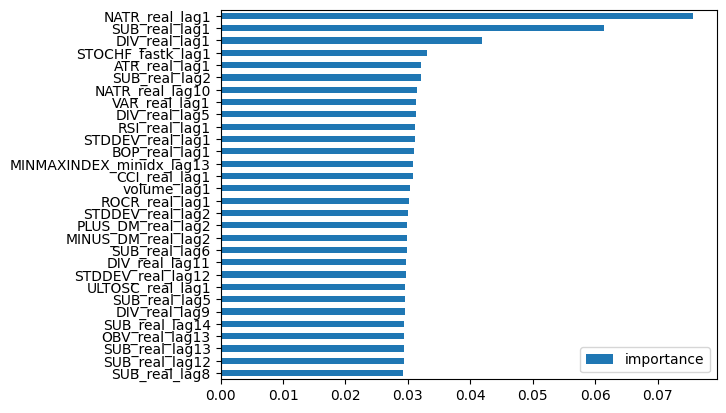

In [108]:
fi = pd.DataFrame(data = clf.feature_importances_,
                  index = clf.feature_names_in_,
                  columns = ['importance'])
fi.sort_values('importance').plot(kind='barh')

In [109]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# 1) Predict labels on the validation set
y_pred = clf.predict(X_val)

# 2) Compute accuracy
val_accuracy = accuracy_score(y_val, y_pred)
print(f"Validation accuracy: {val_accuracy:.4f}")

# 3) (Optional) More diagnostics
print("\nClassification Report:")
print(classification_report(y_val, y_pred))

print("\nConfusion Matrix:")
print(confusion_matrix(y_val, y_pred))


Validation accuracy: 0.5987

Classification Report:
              precision    recall  f1-score   support

           0       0.64      0.47      0.55      3704
           1       0.61      0.65      0.63      3797
           2       0.56      0.67      0.61      3940

    accuracy                           0.60     11441
   macro avg       0.61      0.60      0.60     11441
weighted avg       0.60      0.60      0.60     11441


Confusion Matrix:
[[1752  768 1184]
 [ 451 2460  886]
 [ 518  784 2638]]


In [ ]:
from xgboost import XGBClassifier
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd

# 1) Prepare X and y
X = X_boruta.copy()   
y = y.copy()

# 2) Define model with NO glaring capacity to memorize too easily
xgb = XGBClassifier(
    objective='multi:softprob',
    eval_metric='mlogloss',
    verbosity=100,
    random_state=42,
    use_label_encoder=False,
    n_jobs=-1,
)

# ── Add strong regularizers and minimum‐loss‐reduction (gamma) to the grid ──
param_grid = {
    'n_estimators':      [100, 300, 500],
    'max_depth':         [3, 4, 5],          # shallow trees
    'learning_rate':     [0.01, 0.05, 0.1],  
    'subsample':         [0.6, 0.8, 1.0],     # row sampling
    'colsample_bytree':  [0.6, 0.8, 1.0],     # feature sampling
    'gamma':             [0, 1, 5],          # min loss reduction to split
    'reg_alpha':         [0, 0.5, 1.0],       # L1 regularization
    'reg_lambda':        [1.0, 2.0, 5.0],     # L2 regularization
    'min_child_weight':  [1, 5, 10],         # min sum hessians in leaf
}

# 3) GridSearchCV with train scores turned on
tscv = TimeSeriesSplit(n_splits=N_SPLITS)
grid = GridSearchCV(
    estimator=xgb,
    param_grid=param_grid,
    cv=tscv,
    scoring='accuracy',
    return_train_score=True,
    n_jobs=-1,
    verbose=2
)

# 4) Fit (this runs a separate fit per fold + hyper‐parameter combo)
grid.fit(X, y)

# 5) Summarize best results
best_idx   = grid.best_index_
cv_results = pd.DataFrame(grid.cv_results_)

print("=== Best Parameters ===")
print(grid.best_params_, "\n")

print("=== CV Train vs Validation Accuracy ===")
print(f" Mean TRAIN accuracy (best):      {cv_results.loc[best_idx,'mean_train_score']:.4f} ± {cv_results.loc[best_idx,'std_train_score']:.4f}")
print(f" Mean VALIDATION accuracy (best): {cv_results.loc[best_idx,'mean_test_score']:.4f} ± {cv_results.loc[best_idx,'std_test_score']:.4f}")

delta = cv_results.loc[best_idx,'mean_train_score'] - cv_results.loc[best_idx,'mean_test_score']
print(f" Train–Validation gap: {delta:.4f} {'← overfitting risk' if delta>0.05 else ''}\n")

# ── 6) Optional: Early-stop on each fold for the best combo ─────────────
best_params = grid.best_params_
fold_reports = []
for fold, (train_idx, val_idx) in enumerate(tscv.split(X), 1):
    X_tr, X_val = X.iloc[train_idx], X.iloc[val_idx]
    y_tr, y_val = y.iloc[train_idx], y.iloc[val_idx]

    # re-instantiate with best params + early stopping
    model = XGBClassifier(
        **best_params,
        objective='multi:softprob',
        eval_metric='mlogloss',
        use_label_encoder=False,
        early_stopping_rounds=10,  # stop if no gain for 10 rounds
        verbosity=0,
        n_jobs=-1,
        random_state=42
    )
    # track validation set for early stopping
    model.fit(
        X_tr, y_tr,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    y_pred = model.predict(X_val)
    acc    = (y_pred == y_val).mean()
    print(f"Fold {fold} (with early-stop) accuracy: {acc:.4f}")

    fold_reports.append((y_val, y_pred))

# 7) Aggregate final confusion matrix + report
y_true = pd.concat([t for t, _ in fold_reports])
y_pred = pd.concat([p for _, p in fold_reports])

print("\n=== Aggregated Classification Report ===")
print(classification_report(y_true, y_pred))
print("\n=== Aggregated Confusion Matrix ===")
print(confusion_matrix(y_true, y_pred))


Fitting 5 folds for each of 19683 candidates, totalling 98415 fits
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1.0, subsample=0.6; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1.0, subsample=0.8; total time=   0.3s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1.0, subsample=0.8; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1.0, subsample=0.6; total time=   0.4s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max_depth=3, min_child_weight=1, n_estimators=100, reg_alpha=0, reg_lambda=1.0, subsample=0.8; total time=   0.5s
[CV] END colsample_bytree=0.6, gamma=0, learning_rate=0.01, max

KeyboardInterrupt: 

In [ ]:
best_model = grid.best_estimator_

# Containers for aggregated true & predicted
y_true_all = []
y_pred_all = []

# 1) Loop over each fold
for fold, (train_idx, test_idx) in enumerate(tscv.split(X), 1):
    X_train, X_test = X.iloc[train_idx],  X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx],  y.iloc[test_idx]
    
    # (Re-)fit on train of this fold, or you can skip refit if best_model is fully trained
    best_model.fit(X_train, y_train)
    
    # Predict on the held-out test set
    y_pred = best_model.predict(X_test)
    
    # Store results
    y_true_all.append(y_test)
    y_pred_all.append(pd.Series(y_pred, index=y_test.index))
    
    # Per-fold quick check
    print(f"\nFold {fold} accuracy: { (y_pred == y_test).mean()}:.4f ")

# 2) Concatenate across all folds
y_true = pd.concat(y_true_all)
y_pred = pd.concat(y_pred_all)

# 3) Compute overall metrics
print("\n=== Aggregated Classification Report ===")
print(classification_report(y_true, y_pred))

print("=== Aggregated Confusion Matrix ===")
print(confusion_matrix(y_true, y_pred))


Fold 1 accuracy: 0.4908256880733945:.4f 

Fold 2 accuracy: 0.536697247706422:.4f 

Fold 3 accuracy: 0.4954128440366973:.4f 

Fold 4 accuracy: 0.5412844036697247:.4f 

Fold 5 accuracy: 0.5137614678899083:.4f 

=== Aggregated Classification Report ===
              precision    recall  f1-score   support

           0       0.53      0.54      0.53       517
           1       0.00      0.00      0.00        61
           2       0.51      0.55      0.53       512

    accuracy                           0.52      1090
   macro avg       0.34      0.36      0.35      1090
weighted avg       0.49      0.52      0.50      1090

=== Aggregated Confusion Matrix ===
[[280   2 235]
 [ 21   0  40]
 [230   0 282]]


In [53]:
# In[1]: Imports & Setup
import os
import urllib.parse
from dotenv import load_dotenv
import pandas as pd
import numpy as np
from sqlalchemy import create_engine
from sklearn.ensemble import RandomForestClassifier
from boruta import BorutaPy


# Define feature matrix X and target y
feature_cols = [c for c in X_lagged.columns]
X = X_lagged[feature_cols]

rf_mc = RandomForestClassifier(
    n_jobs=-1,
    class_weight='balanced',
    random_state=42
)

boruta_mc = BorutaPy(
    estimator=rf_mc,
    n_estimators='auto',
    verbose=2,
    random_state=42
)
boruta_mc.fit(X.values, y.values)
boruta_selected_mc = list(X.columns[boruta_mc.support_])
print("Boruta selected (multiclass):", boruta_selected_mc)


Iteration: 	1 / 100
Confirmed: 	0
Tentative: 	567
Rejected: 	0
Iteration: 	2 / 100
Confirmed: 	0
Tentative: 	567
Rejected: 	0
Iteration: 	3 / 100
Confirmed: 	0
Tentative: 	567
Rejected: 	0
Iteration: 	4 / 100
Confirmed: 	0
Tentative: 	567
Rejected: 	0
Iteration: 	5 / 100
Confirmed: 	0
Tentative: 	567
Rejected: 	0
Iteration: 	6 / 100
Confirmed: 	0
Tentative: 	567
Rejected: 	0
Iteration: 	7 / 100
Confirmed: 	0
Tentative: 	567
Rejected: 	0
Iteration: 	8 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	563
Iteration: 	9 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	563
Iteration: 	10 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	563
Iteration: 	11 / 100
Confirmed: 	0
Tentative: 	4
Rejected: 	563
Iteration: 	12 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	564
Iteration: 	13 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	564
Iteration: 	14 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	564
Iteration: 	15 / 100
Confirmed: 	0
Tentative: 	3
Rejected: 	564
Iteration: 	16 / 100
Confirmed: 	0
Tentative: 	3


In [54]:
## In[3]: Genetic Algorithm (wrapper) for multiclass
from genetic_selection import GeneticSelectionCV

estimator_mc = RandomForestClassifier(n_jobs=-1, random_state=42)
selector_mc = GeneticSelectionCV(
    estimator=estimator_mc,
    cv=5,
    scoring='accuracy',
    n_population=50,
    crossover_proba=0.5,
    mutation_proba=0.2,
    n_generations=40,
    n_jobs=-1,
    max_features=50,
    verbose=1
)
selector_mc.fit(X.values, y.values)
ga_selected_mc = list(X.columns[selector_mc.support_])
print("GA selected (multiclass):", ga_selected_mc)

Selecting features with genetic algorithm.
gen	nevals	avg                               	std                               	min                            	max                               
0  	50    	[  0.382682  26.04       0.114117]	[  0.026729  14.714564   0.027049]	[ 0.308646  1.        0.00449 ]	[  0.474403  50.         0.165075]
1  	19    	[-999.633953   24.26     1000.083629]	[ 3000.122016    17.859239  2999.972124]	[-10000.           1.           0.00449]	[     0.474403     70.        10000.      ]
2  	32    	[-199.58568    18.88      200.072175]	[ 1400.059189    15.549457  1399.98969 ]	[-10000.           1.           0.00449]	[     0.474403     55.        10000.      ]
3  	30    	[  0.438599  11.6        0.053795]   	[  0.037292  12.814055   0.044314]      	[ 0.365251  1.        0.00449 ]         	[  0.488143  46.         0.134526]         
4  	32    	[-199.557499    9.18      200.038171]	[ 1400.063215    13.220726  1399.994548]	[-10000.           0.           0.00449]	[    

In [ ]:
## In[4]: LightGBM embedded for multiclass
import lightgbm as lgb

lgbm_mc = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=3,
    random_state=42
)
lgbm_mc.fit(X, y)
importances_mc = pd.Series(
    lgbm_mc.feature_importances_, index=X.columns
)
lgbm_selected_mc = list(importances_mc.nlargest(30).index)
print("LightGBM top 15 (multiclass):", lgbm_selected_mc)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006444 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 111311
[LightGBM] [Info] Number of data points in the train set: 1309, number of used features: 544
[LightGBM] [Info] Start training from score -0.744079
[LightGBM] [Info] Start training from score -2.972326
[LightGBM] [Info] Start training from score -0.747299
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM top 15 (multiclass): ['BOP_real_lag1', 'DIV_real_lag14', 'COS_real_lag3', 'STOCHF_fastk_lag1', 'COS_real_lag8', 'HT_PHASOR_quadrature_lag7', 'TAN_real_lag9', 'COS_real_lag1', 'COS_real_lag10', 'ret1_lag7', 'ret1_lag14', 'TAN_real_lag7', 'COS_real_lag9', 'BETA_real_lag7', 'BOP_real_lag2']


In [ ]:
# methods = {
#     'Boruta': boruta_selected_mc,
#     'Genetic Algorithm': ga_selected_mc,
#     'LightGBM': lgbm_selected_mc
# }

# import matplotlib.pyplot as plt
# import seaborn as sns

# ## In[3]: Correlation computations and heatmaps
# for name, feats in methods.items():
#     # Subset features + ret1
#     sub_df = df_all[feats + ['ret1']].copy()
    
#     # Compute correlation matrix
#     corr = sub_df.corr()
    
#     # Print correlation of each feature with ret1
#     print(f"\n{name} features ↔ future return (ret1):")
#     print(corr['ret1'].drop('ret1').to_frame().T)
    
#     # Plot heatmap
#     plt.figure(figsize=(max(4, len(feats)*0.6), max(4, len(feats)*0.6)))
#     sns.heatmap(corr, annot=False, cmap='RdBu_r', vmin=-1, vmax=1)
#     plt.title(f"{name} Features Correlation Matrix")
#     plt.tight_layout()
#     plt.show()

KeyError: "['DIV_real_lag14'] not in index"

In [61]:
# ── Imports ────────────────────────────────────────────────────────────────
import numpy as np
import pandas as pd
from sklearn.model_selection import TimeSeriesSplit
import optuna
from optuna.samplers import TPESampler
import xgboost as xgb
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    balanced_accuracy_score,
    roc_auc_score,
    precision_recall_fscore_support,
)

def tune_xgb(X, y, n_splits=3, test_size=365, n_trials=30, seed=42):
    """
    Return best‑params dict for multiclass softprob XGBoost.
    """
    tscv = TimeSeriesSplit(n_splits=n_splits, test_size=test_size)
    sampler = TPESampler(seed=seed)

    def objective(trial):
        params = {
            "objective":        "multi:softprob",
            "num_class":        3,
            "eval_metric":      "mlogloss",
            "max_depth":        trial.suggest_int("max_depth", 3, 10),
            "eta":              trial.suggest_float("eta", 0.01, 0.2, log=True),
            "subsample":        trial.suggest_float("subsample", 0.5, 1.0),
            "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
            "gamma":            trial.suggest_float("gamma", 0.0, 5.0),
            "lambda":           trial.suggest_float("lambda", 0.0, 5.0),
            "seed":             seed,
        }

        f1s = []
        for tr_idx, te_idx in tscv.split(X):
            dtr = xgb.DMatrix(X[tr_idx], label=y[tr_idx])
            dte = xgb.DMatrix(X[te_idx], label=y[te_idx])

            bst = xgb.train(
                params,
                dtr,
                num_boost_round=800,
                evals=[(dtr, "train"), (dte, "valid")],
                early_stopping_rounds=50,
                verbose_eval=False,
            )
            pred = np.argmax(bst.predict(dte), axis=1)
            f1s.append(f1_score(y[te_idx], pred, average="macro", zero_division=0))

        # Optuna **minimises** — return negative macro‑F1
        return -np.mean(f1s)

    study = optuna.create_study(
        sampler=sampler, direction="minimize", study_name="xgb_mc_tune"
    )
    study.optimize(objective, n_trials=n_trials, show_progress_bar=False)

    best_params = study.best_params
    # add fixed params back:
    best_params.update({
        "objective": "multi:softprob",
        "num_class": 3,
        "eval_metric": "mlogloss",
        "seed": seed,
    })
    print("Best params:", best_params)
    return best_params


# # ── ❶ Create 3‑class direction target (‑1 / 0 / 1) ─────────────────────────
# delta = 0.001
# df_final["ret1"] = df_final["close"].pct_change().shift(-1)
# df_final.dropna(subset=["ret1"], inplace=True)

# df_final["y_mc"] = np.where(
#     df_final["ret1"] >  delta,  2,
#     np.where(df_final["ret1"] < -delta, 0, 1)
# )

# print("Encoded‑class distribution:\n", df_final["y_mc"].value_counts())

# ── ❷ Put your selected feature lists here ────────────────────────────────
boruta_feats = boruta_selected_mc          # e.g. ['MOM_real']
ga_feats     = ga_selected_mc              # list from GA
lgbm_feats   = lgbm_selected_mc            # top‑K from LightGBM

feature_sets = {
    "Boruta" : boruta_feats,
    "Genetic": ga_feats,
    "LightGBM": lgbm_feats,
}

# ── ❸ Time‑series CV and XGBoost training ──────────────────────────────────
tscv   = TimeSeriesSplit(n_splits=3, test_size=365)  # 1‑year hold‑out per split
models = {}
results = {name: [] for name in feature_sets}

for name, feats in feature_sets.items():
    if not feats:          # safety check
        print(f"[WARN] {name} feature list is empty; skipping.")
        continue

    print(f"\n=== XGBoost ({name}) on {len(feats)} features ===")
    # X = df_final[feats].values
    # y = df_final["y_mc"].values          # 0,1,2 labels

    # — walk‑forward CV —
    for fold, (tr, te) in enumerate(tscv.split(X), 1):
        dtrain = xgb.DMatrix(X[tr], label=y[tr])
        dtest  = xgb.DMatrix(X[te], label=y[te])

        best_params = tune_xgb(X, y, n_trials=30)   # adjust trials if you like
        params = best_params

        bst = xgb.train(
            params,
            dtrain,
            num_boost_round=800,
            evals=[(dtrain, "train"), (dtest, "valid")],
            early_stopping_rounds=30,
            verbose_eval=False,
        )

        proba = bst.predict(dtest)                       # shape (n_samples, 3)
        y_pred = np.argmax(proba, axis=1)

        acc  = accuracy_score(y[te], y_pred)
        bacc = balanced_accuracy_score(y[te], y_pred)
        f1w  = f1_score(y[te], y_pred, average="weighted", zero_division=0)
        f1m  = f1_score(y[te], y_pred, average="macro", zero_division=0)
        auc  = roc_auc_score(y[te], proba, multi_class="ovr", average="macro")

        prec, rec, f1_per_cls, _ = precision_recall_fscore_support(
            y[te], y_pred, zero_division=0
        )

        print(f"Fold {fold}  Acc={acc:.4f}  BalAcc={bacc:.4f}  F1(macro)={f1m:.4f}")

        results[name].append(
            {
                "fold": fold,
                "accuracy": acc,
                "balanced_acc": bacc,
                "f1_weighted": f1w,
                "f1_macro": f1m,
                "auc_macro": auc,
                "precision_cls": prec,
                "recall_cls":    rec,
                "f1_cls":        f1_per_cls,
                "n_estimators":  bst.best_iteration or 800,
            }
        )

    # — final model on full data —
    full_dm   = xgb.DMatrix(X, label=y)
    bst_final = xgb.train(
        params,
        full_dm,
        num_boost_round=bst.best_iteration or 800,
        verbose_eval=False,
    )

    model_path = f"xgb_{name.lower()}_dir.json"
    bst_final.save_model(model_path)
    models[name] = bst_final
    print(f"Saved {model_path}")



=== XGBoost (Boruta) on 1 features ===


KeyError: "None of [Index([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,\n       ...\n       204, 205, 206, 207, 208, 209, 210, 211, 212, 213],\n      dtype='int64', length=214)] are in the [columns]"

In [204]:
for name, recs in results.items():
    df_res = pd.DataFrame(recs)
    print(f"\n=== {name}  cross‑validation summary ===")
    print(df_res[["fold","accuracy","balanced_acc","f1_macro","auc_macro"]])
    print("\nMean metrics:")
    print(df_res.drop(columns=["fold","precision_cls","recall_cls","f1_cls","n_estimators"])
            .mean())


=== Boruta  cross‑validation summary ===
   fold  accuracy  balanced_acc  f1_macro  auc_macro
0     1  0.424658      0.369255  0.359640   0.570623
1     2  0.408219      0.395599  0.396494   0.551572
2     3  0.460274      0.446499  0.447457   0.588731

Mean metrics:
accuracy        0.431050
balanced_acc    0.403784
f1_weighted     0.416372
f1_macro        0.401197
auc_macro       0.570309
dtype: float64

=== LightGBM  cross‑validation summary ===
   fold  accuracy  balanced_acc  f1_macro  auc_macro
0     1  0.430137      0.378573  0.380635   0.560924
1     2  0.452055      0.429083  0.427797   0.578959
2     3  0.430137      0.415921  0.424070   0.567414

Mean metrics:
accuracy        0.437443
balanced_acc    0.407859
f1_weighted     0.427557
f1_macro        0.410834
auc_macro       0.569099
dtype: float64
